In [75]:
%matplotlib inline
from nltk.corpus import brown
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re
import nltk
from collections import Counter
from itertools import chain
from scipy.sparse import hstack

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Classifying Brown

As discussed previously, one of the first steps we wanted to take was to classify books into fiction and non fiction. In the brown corpus, this is pretty clear for most genres, with one exception. Humor (9 documents) is a mix of fiction and non-fiction. I couldn't immediately find information on which was which, so I just excluded it from the data.


In [2]:
df = pd.DataFrame({'fileid':[i for i in brown.fileids()]})
df['text'] = df.fileid.apply(lambda x: ' '.join(brown.words(fileids=x)))
df['category'] = df.fileid.apply(lambda x: brown.categories(fileids=x)[0])

In [4]:
category_dict={'adventure': 'Fiction',
              'belles_lettres': 'Nonfiction',
              'editorial': 'Nonfiction',
              'fiction': 'Fiction',
              'government': 'Nonfiction',
              'hobbies': 'Nonfiction',
              'humor': 'Humor',
              'learned': 'Nonfiction',
              'lore': 'Nonfiction',
              'mystery': 'Fiction',
              'news': 'Nonfiction',
              'religion': 'Nonfiction',
              'reviews': 'Nonfiction',
              'romance': 'Fiction',
              'science_fiction': 'Fiction'}
df['fiction'] = df.category.map(category_dict)
df = df[df.fiction!='Humor']

In [5]:
df.fiction.value_counts()

Nonfiction    374
Fiction       117
Name: fiction, dtype: int64

The data features a slight imbalance -- there are about three times as many nonfiction documents as there are fiction. This could pose a problem for classification, but as we will see, it turns out that simple models to a pretty good job on these data.

To evaluate performance, I set up a 10-fold cross validation experiment with a multinomial naiive bayes classifier. The input to this model is a very simple unigram bag-of-words. 

In [6]:
rs = ShuffleSplit(n_splits=10)
scores = []
conf = np.array([[0,0],[0,0]])
le = preprocessing.LabelEncoder()
le.fit(df.fiction)
text_clf = Pipeline([('vect', CountVectorizer()),
                    ('clf', MultinomialNB())])

In [7]:
for train, test in rs.split(df.text):
    x_train = df.iloc[train]['text'].values
    y_train = le.transform(df.iloc[train]['fiction'].values)
    
    x_test = df.iloc[test]['text'].values
    y_test = le.transform(df.iloc[test]['fiction'].values)
    
    text_clf.fit(x_train, y_train)
    preds = text_clf.predict(x_test)
    
    conf += confusion_matrix(y_test, preds)
    score = f1_score(y_test, 
                     preds, pos_label=0)
    scores.append(score)

Average F1 score for fiction class across 10 folds = 0.853002957826
SD of F1 score = 0.088710319931


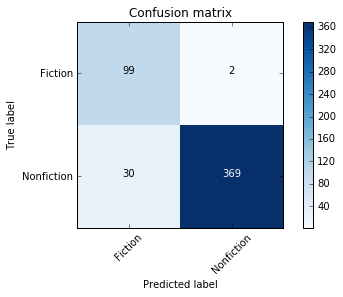

In [8]:
plot_confusion_matrix(conf, classes=le.classes_ )
print ('Average F1 score for fiction class across 10 folds = %s' %np.mean(scores))
print ('SD of F1 score = %s' % np.std(scores))

The figure above shows the confusion matrix for the problem. Clearly, this was not a terribly difficult task, but there's also a little room for improvement. To what extent can we replicate this on other data? We can test the same idea using the MASC data. Unfortunately, this dataset is quite a bit smaller.

# Classifying the MASC corpus

In [9]:
import lxml.etree as etree
from bs4 import BeautifulSoup
import glob

files = glob.glob('data/*/*.xml')
entities = {'person': 0, 'org':0, 'location':0, 'date':0}
text = []
category = []
fileid = []
for f in files:
    xml_data = open(f).read()
    soup = BeautifulSoup(xml_data, 'lxml')
    text.append(soup.text)
    category.append(re.findall('data/(.+)/',f)[0])
    fileid.append(re.findall('data/.+/(.+)',f)[0])

In [10]:
df_masc = pd.DataFrame({'fileid':[i for i in fileid],
                        'text':[i for i in text],
                       'category':[i for i in category]})

In [11]:
category_dict={'newspaper': 'Nonfiction',
              'essays': 'Nonfiction',
              'technical': 'Nonfiction',
              'fiction': 'Fiction',
              'travel_guides': 'Nonfiction',
              'non_fiction': 'Nonfiction',
              'ficlits': 'Fiction',
              'govt_docs': 'Nonfiction'}
df_masc['fiction'] = df_masc.category.map(category_dict)
df_masc.fiction.value_counts()

Nonfiction    85
Fiction       12
Name: fiction, dtype: int64

The imbalance here is quite a bit worse than the Brown corpus. There are nearly 7 times the number of nonfiction examples as fiction examples. Given how easy the previous classification problem was, this might pose a good test for how easy this problem is. 

Evaluation is the same as for the Brown Corpus, with the same classifier and features.

In [12]:
rs = ShuffleSplit(n_splits=10)
scores = []
conf = np.array([[0,0],[0,0]])
le = preprocessing.LabelEncoder()
le.fit(df_masc.fiction)
text_clf = Pipeline([('vect', CountVectorizer()),
                    ('clf', MultinomialNB())])

In [13]:
for train, test in rs.split(df_masc.text):
    x_train = df_masc.iloc[train]['text'].values
    y_train = le.transform(df_masc.iloc[train]['fiction'].values)
    
    x_test = df_masc.iloc[test]['text'].values
    y_test = le.transform(df_masc.iloc[test]['fiction'].values)
    
    text_clf.fit(x_train, y_train)
    preds = text_clf.predict(x_test)
    
    
    conf += confusion_matrix(y_test, preds)
    score = f1_score(y_test, 
                     preds, pos_label=0)
    scores.append(score)

/Users/triddle/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Average F1 score for Fiction across 10 folds = 0.8
SD of F1 score = 0.4


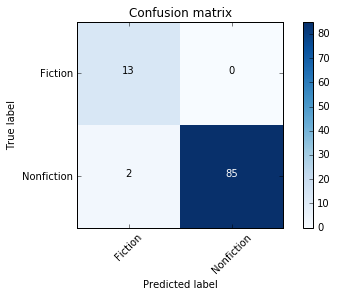

In [14]:
plot_confusion_matrix(conf, classes=le.classes_)
print ('Average F1 score for Fiction across 10 folds = %s' %np.mean(scores))
print ('SD of F1 score = %s' % np.std(scores))

The performance here is a bit worse than the Brown corpus, though this isn't too surprising, as there's less data to work with here. However, it still appears that there's a good signal in these data for classification, as performance is still relatively good.

# Combined corpora

As both of these corpora are on the small side, we can get a better sense of performance by using the combined data on the same classification problem.

In [15]:
df_combined = pd.concat([df, df_masc])
rs = ShuffleSplit(n_splits=10)
scores = []
conf = np.array([[0,0],[0,0]])
le = preprocessing.LabelEncoder()
le.fit(df_combined.fiction)
text_clf = Pipeline([('vect', CountVectorizer()),
                    ('clf', MultinomialNB())])

In [16]:
for train, test in rs.split(df_combined.text):
    x_train = df_combined.iloc[train]['text'].values
    y_train = le.transform(df_combined.iloc[train]['fiction'].values)
    
    x_test = df_combined.iloc[test]['text'].values
    y_test = le.transform(df_combined.iloc[test]['fiction'].values)
    
    text_clf.fit(x_train, y_train)
    preds = text_clf.predict(x_test)
    
    
    conf += confusion_matrix(y_test, preds)
    score = f1_score(y_test, 
                     preds, pos_label=0)
    scores.append(score)

Average F1 score for Fiction across 10 folds = 0.888437904367
SD of F1 score = 0.0549244580671


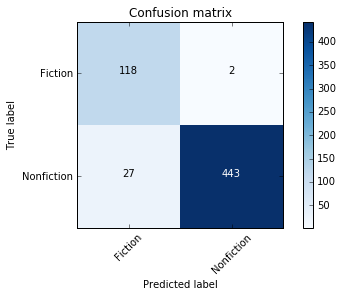

In [17]:
plot_confusion_matrix(conf, classes=le.classes_)
print ('Average F1 score for Fiction across 10 folds = %s' %np.mean(scores))
print ('SD of F1 score = %s' % np.std(scores))

This performance is roughly on par with what we saw using just the brown corpus. If we want to see improvements, it seems as though we'll need to do some feature engineering or change the classifier. As a first approach, I'll incorporate some Part-of-speech features.

# Part-of-speech data

In [18]:
tag_words = lambda x: nltk.pos_tag(nltk.word_tokenize(x))
df_combined['tagged_data'] = df_combined.text.apply(tag_words)

all_tags = sorted(set(list(zip(*chain(*df_combined['tagged_data'])))[1]))

def add_pos_with_zero_counts(counter, keys_to_add):
    for k in keys_to_add:
        counter[k] = counter.get(k, 0)
    return counter

df_combined['pos_counts'] = df_combined['tagged_data'].apply(lambda x: Counter(list(zip(*x))[1]))
df_combined['pos_counts_with_zero'] = df_combined['pos_counts'].apply(lambda x: add_pos_with_zero_counts(x, all_tags))
df_combined['sent_vector'] = df_combined['pos_counts_with_zero'].apply(lambda x: [count for tag, count in sorted(x.most_common())])
df_tags = pd.DataFrame(df_combined['sent_vector'].tolist())
df_tags.columns = all_tags

In [19]:
rs = ShuffleSplit(n_splits=10)
scores = []
conf = np.array([[0,0],[0,0]])
le = preprocessing.LabelEncoder()
le.fit(df_combined.fiction)
#text_clf = Pipeline([('vect', CountVectorizer()),
#                    ('clf', MultinomialNB())])
count_vect = CountVectorizer()
clf = MultinomialNB()

In [22]:
for train, test in rs.split(df_combined.text):
    text_train = df_combined.iloc[train]['text'].values
    pos_train = df_tags.iloc[train]
    y_train = le.transform(df_combined.iloc[train]['fiction'].values)
    
    text_test = df_combined.iloc[test]['text'].values
    pos_test = df_tags.iloc[test]
    y_test = le.transform(df_combined.iloc[test]['fiction'].values)
    
    train_counts = count_vect.fit_transform(text_train)
    x_train = hstack([train_counts, pos_train])
    test_counts = count_vect.transform(text_test)
    x_test = hstack([test_counts, pos_test])
    
    
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    
    
    conf += confusion_matrix(y_test, preds)
    score = f1_score(y_test, 
                     preds, pos_label=0)
    scores.append(score)

Average F1 score for Fiction across 10 folds = 0.901205061483
SD of F1 score = 0.0785927429999


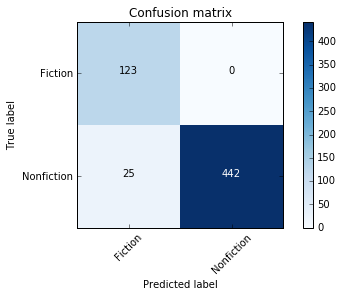

In [23]:
plot_confusion_matrix(conf, classes=le.classes_)
print ('Average F1 score for Fiction across 10 folds = %s' %np.mean(scores))
print ('SD of F1 score = %s' % np.std(scores))

Adding the POS features had a positive effect on performance. We can see that the F1 score improved by a few points (from .87 to .93), and the variance of the performance across the folds has also gone down, (from a SD of .08 to .05), suggesting more stable performance on this task.

# Classification summary

Apparently picking out fictional vs non-fictional works is not terribly difficult. There are certainly a number of thing we could try to improve these results. In particular, I have not bothered attempting to tune hyperparameters, nor did I try out any other representations of the corpus (e.g. tf-idf, ngram > 1). I also didn't try using any other classifiers or using any methods to deal with unbalanced data. It seems probable that at least one of these (or some combination of them) could yield some improvements in performance. 

# Clustering fiction works

Having shown that we can accurately classify works based on whether they are fictional or not, I will now move on to exploring whether we can cluster documents in ways that would correspond to genre labels. I am using an unsupervised approach here because we have very few examples to work with. In particular, the MASC corpus has only 12 fictional works, and they are not further annotated by genre. The Brown corpus does provide some annotations by genre, but the labeling is inconsistent. For instance, although there are labels for science fiction (n=6), mystery (n=24), adventure (n=29) and romance (n=29), there's also a label for fiction (n=29). Presumably the former categories are also fiction, so it isn't clear what the basis of these labels are.

Regardless, this gives us 5 categories that are clearly labeled + fiction. This seems to suggest a baseline attempt of 6 categories.

In [77]:
from sklearn import cluster
from sklearn.preprocessing import normalize
k = 2
kmeans = cluster.KMeans(n_clusters=k)

df_clustering = df_combined[df_combined.fiction=='Fiction']
df_tags = pd.DataFrame(df_clustering['sent_vector'].tolist())
df_tags.columns = all_tags
X = hstack([count_vect.fit_transform(df_clustering.text, ), df_tags])
X = normalize(X) #varying document lengths
kmeans.fit(X)

/Users/triddle/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [88]:
from sklearn.decomposition import TruncatedSVD
labs = kmeans.labels_
cents = kmeans.cluster_cent
svd = TruncatedSVD(2)
columns = svd.fit_transform(X)
k_locs = svd.transform(cents)

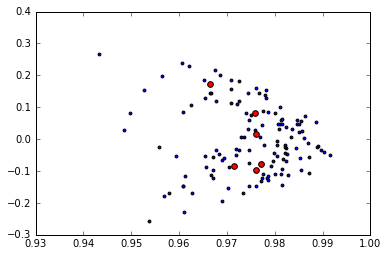

In [99]:
plt.scatter(x=columns[:,0], y=columns[:,1], s=8)
plt.scatter(x=k_locs[:,0], y=k_locs[:,1], s=32, c='r')
plt.show()

In [123]:
df_clustering['k_labs'] = labs
df_clustering['k_labs'] = df_clustering['k_labs'].apply(str)
confusion_matrix(df_clustering.k_labs, df_clustering.category)[0:6, 6:]

array([[ 3,  0,  3,  5,  4,  1],
       [ 6,  0, 13,  2,  9,  2],
       [ 3,  0,  3,  4,  7,  0],
       [ 6,  5,  4,  6,  7,  2],
       [ 9,  0,  7,  4,  0,  0],
       [ 2,  0,  6,  3,  2,  1]])

A naive approach to this problem turned out to not work very well. I came to this conclusion because there's no clear separation when plotting the first two principal components of the X matrix, and an examination of the cluster assignments against the observed category labels doesn't provide much confidence that the method is giving sensible assignments (i.e. there are a lot of observations in the off-diagonal elements of the matrix above)


# Classifying category?
Given that the cursory attempt above was not terribly successful, I wanted to see what would happen with the same classification approach I'd previously taken. As we will see, there are some problems with this approach too. Most notably, we're now working with an extremely small number of examples to learn from. After removing the undifferentiated 'fiction' category, we're down to 93 documents. The majority of these documents are in the *adventure* and *romance* classes. Despite these limitations (and the relatively simplistic approach), I'm hopeful that this method would scale well with more examples.

In [158]:
scores = []

df_combined = df_combined[df_combined.fiction=='Fiction']
df_combined = df_combined[df_combined.category!='fiction']
df_tags = pd.DataFrame(df_clustering['sent_vector'].tolist())
df_tags.columns = all_tags

preds = np.zeros(1)
labs = np.zeros(1)
conf = np.zeros((5,5))
le = preprocessing.LabelEncoder()
le.fit(df_combined.category)
#text_clf = Pipeline([('vect', CountVectorizer()),
#                    ('clf', MultinomialNB())])
count_vect = CountVectorizer()
clf = MultinomialNB()

for train, test in rs.split(df_combined.text):
    text_train = df_combined.iloc[train]['text'].values
    pos_train = df_tags.iloc[train]
    y_train = le.transform(df_combined.iloc[train]['category'].values)
    
    text_test = df_combined.iloc[test]['text'].values
    pos_test = df_tags.iloc[test]
    y_test = le.transform(df_combined.iloc[test]['category'].values)
    
    train_counts = count_vect.fit_transform(text_train)
    x_train = hstack([train_counts, pos_train])
    test_counts = count_vect.transform(text_test)
    x_test = hstack([test_counts, pos_test])
    
    
    clf.fit(x_train, y_train)
    preds = np.append(preds, clf.predict(x_test))
    labs = np.append(labs, y_test)
    
    #conf += confusion_matrix(y_test, preds)
    score = f1_score(y_test, 
                     clf.predict(x_test), average='macro')
    scores.append(score)

Average F1 macro score for genre across 10 folds = 0.529511904762
SD of F1 score = 0.132810074975


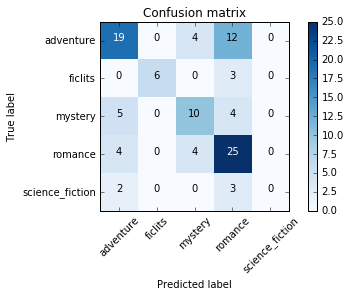

In [159]:
plot_confusion_matrix(confusion_matrix(labs, preds), classes=le.classes_)
print ('Average F1 macro score for genre across 10 folds = %s' %np.mean(scores))
print ('SD of F1 score = %s' % np.std(scores))

The confusion matrix above indicates that the categories for which we have many examples are learned pretty well. Unfortunately, the data sent by Dan at this stage does not have any genre labels that we can work with. If we want to seek out additional genre tags, we could return to the Gutenberg Corpus. Although the tags are not organized in a transparent fashion, it may still be possible to use them to assign one of a smaller handful of labels. For instance, [Wallace](http://bigdata.cs.brown.edu/thesis.pdf) used a clustering approach based on tag assignments. Although the gutenberg corpus might not be relevant, I think Audrey mentioned that they had applied some user tagging to some subset (/all?) of their data. So we may be able to work with that if gutenberg isn't appropriate